In [1]:
from scipy.stats import (
    binom
)
import numpy as numpy
from seaborn import displot
from matplotlib import pyplot
import seaborn
import random

import sys
sys.path.append('.')

In [2]:
def inverse_plot_colorscheme():
    import cycler
    def invert(color_to_convert): 
        table = str.maketrans('0123456789abcdef', 'fedcba9876543210')
        return '#' + color_to_convert[1:].lower().translate(table).upper()
    update_dict = {}
    for key, value in pyplot.rcParams.items():
        if value == 'black':
            update_dict[key] = 'white'
        elif value == 'white':
            update_dict[key] = 'black'
    
    old_cycle = pyplot.rcParams['axes.prop_cycle']
    new_cycle = []
    for value in old_cycle:
        new_cycle.append({
            'color': invert(value['color'])
        })
    pyplot.rcParams.update(update_dict)
    pyplot.rcParams['axes.prop_cycle'] = cycler.Cycler(new_cycle)
    lec = pyplot.rcParams['legend.edgecolor']
    lec = str(1 - float(lec))
    pyplot.rcParams['legend.edgecolor'] = lec

In [3]:
inverse_plot_colorscheme()

Прикладная статистика помогает правильно интерпретировать данные и принимать на основе сделанных выводов обоснованные решения

Пусть вы придумали стартап по доставке одежды и пытаетесь убедить инвесторов, что ваш бизнес выгоден и им стоит в него вложиться. На свои средства вы организовали 30 доставок и на 19 из них клиенты не отказались от доставки (на доставку товара тратится 500 рублей, клиент платит за него 1000 рублей, если клиент откажется, то вы потеряете деньги)

Может показаться, что бизнес прибыльный, с наших доставок мы получили прибыль, но как понять что это не статистический шум?

Положим вероятность того, что клиент не откажется от заказа $\mu = 0.5$ и математически смоделируем, какие могли быть статусы наших 30 заказов.

In [18]:
statuses = []
for _ in range(30):  # моделируем 30 доставок
    status = random.randint(0, 1)  # генерируем случайное число, 0 или 1
    statuses.append(status)
exp_chance = sum(statuses) / 30

In [19]:
print('Доля успехов: {:.0%}'.format(exp_chance))

Доля успехов: 50%


В примере доля успеха была $\frac{19}{30} = 63\%$, компьютерное моделирование показывает, что в предположение $\mu = 0.5$ результаты бывают и ниже 50%

Будем пытаться ответить на вопрос **Насколько часто может быть такое, что при $\mu = 0.5$ получается большая доля успехов**?

Для этого обратимся к теории вероятностей. Успешность каждого заказа &mdash; это случайная величина $\xi$ из распределения Бернулли. Параметр этого распределения, вероятность успеха, мы не знаем.

$$ \xi = \xi_1, \xi_2, \dots, \xi_{30} \sim Bern(\mu) - \text{выборка} $$

$$ \mu - \text{неизвестный параметр} $$

В статистике рассматривают две гипотезы. Нулевая гипотеза говорит о том, что мы хотим опровергнуть. Альтернативная гипотеза говорит о том, что мы хотим доказать.

$$ \mathsf{H}_0: \mu = 0.5 $$
$$ \mathsf{H}_1: \mu > 0.5 $$

Количество успехов &mdash; это сумма независимых бернуллиевских величин, значит имеет биномиальное распределение

In [20]:
binom_h0 = binom(
    n=30, # количество испытаний
    p=0.5 # вероятность успеха
)

In [21]:
# координата
x_grid = numpy.arange(1, 31)
# высота столбцов на графике
probs = binom_h0.pmf(x_grid)

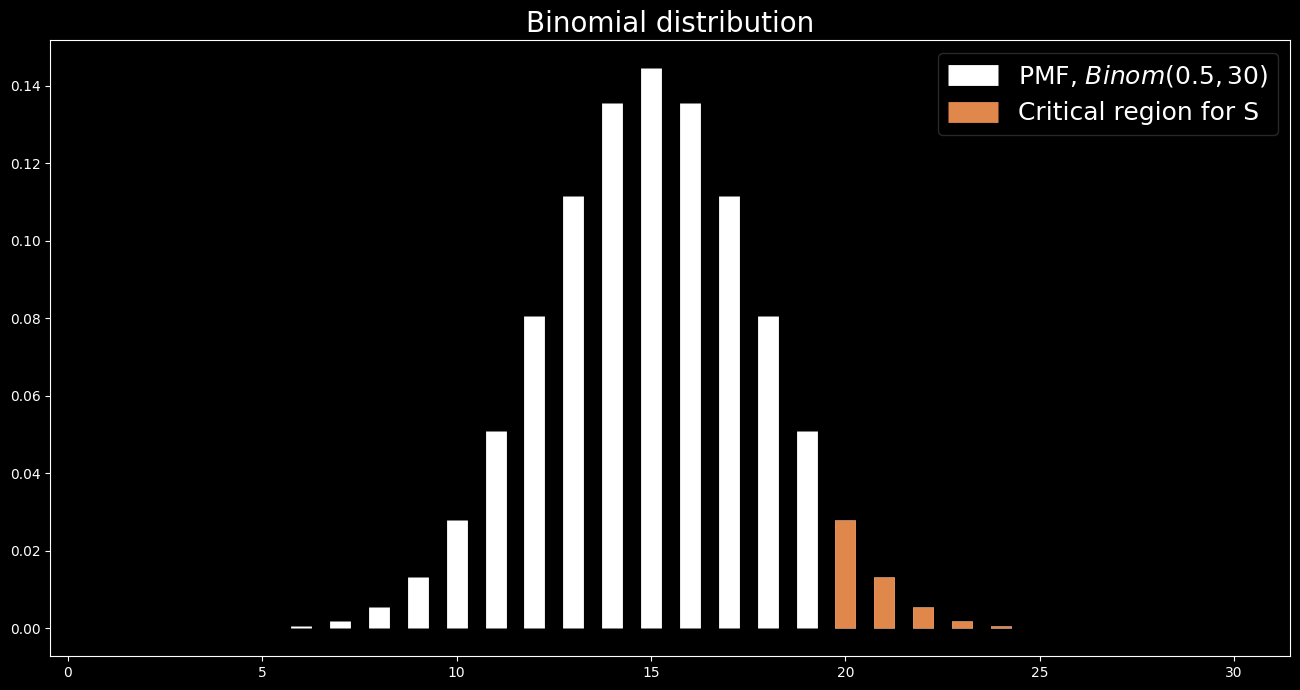

In [22]:
pyplot.figure(figsize=(16, 8))

# строим вертикальные столбцы от 0 до вероятности
pyplot.vlines(x_grid, 0, probs, linewidth=15.0, color='white', label='PMF, $Binom(0.5, 30)$')
# отдельно изобразим критическую области критерия
crit_reg = x_grid >= 20
pyplot.vlines(x_grid[crit_reg], 0, probs[crit_reg], linewidth=15.0, label='Critical region for S')

pyplot.title('Binomial distribution', fontsize=20)
pyplot.legend(fontsize=18)
pyplot.show()

Критерием называется правило, которое по выборке позволяет определить отвергаем ли мы нулевую гипотезу или нет

$$
S(\xi) = \begin{cases}
    1, \text{ если отвергаем } \mathsf{H}_0 \\
    0, \text{ иначе}
\end{cases}
$$

В нашей задаче мы смотрим не на саму выборку, а на количество принятых заказов - то есть на сумму $\xi_i$

$$
Q(\xi) = \sum \xi_i
$$

Такие величины, на которые мы смотрим при построение критерия называются статистиками(другими примерами могут служить выборочное среднее, максимальная порядковая статистика. В формальной теорией статистикой называется любое отображение, сопоставляющее выборке число)

Из картинки выше видно, что $Q(\xi) \geqslant 20\$ случается довольно редко, поэтому критерием для нашей задачи примем

$$ S = \{Q(\xi) \geqslant C\} $$

Где C = 20. Такое C в теории называется критическим значением

Но как искать C? 

Для этого нужно задаться следующим вопросом: **Насколько часто может быть такое, что при справедливости $\mathsf{H}_0$ критерий $S$ отвергает гипотезу**?

Для ответа на него вводятся понятия ошибки I и II рода

Ошибка I рода (или False Positive Rate FPR) - это вероятность того, что критерий скажет принять 1ую гипотезу, хотя на самом деле верна H0

Ошибка II рода (или False Negative Rate FPR) - это вероятность того, что критерий скажет принять 0ую гипотезу, хотя на самом деле верна H1

Пока что будем смотреть на FPR, она важнее для инвесторов в нашей задаче

Посчитаем FPR для нашего критерий

$$ FPR = P(S(\xi) = 1\ |\  \mathsf{H}_0) = P(Q \geqslant 20\ |\ \mathsf{H}_0) = P(Q \geqslant 20\ |\ \mu = 0.5) = $$

$$ = P(Q \geqslant 20\ |\ Q \sim Binom(0.5, 30)) $$

$$ FPR \approx 0.049 $$

Если False Positive Rate не превышает некоторой константы $\alpha$, то критерий называется критерием **уровня значимости** $\alpha$

Обычно берут $\alpha = 0.05$

Наш критерий как раз является критерием именно такого уровня

Но как можно было найти С по уровню стат значимости, а не наоборот? Тут всё ясно, если вспомнить про функцию распределения

Если F - ф.р. $\xi$, то p-квантилью называется такая точка, что вероятность нахождения с.в. левее этой точки >= p, а вероятность нахождения правее её >= 1 - p

$$ u_p(\xi) = sup\{x\ | F_\xi(x) \leq p\} $$

Тогда, чтобы найти C из соображения $\alpha \leq 0.05$ нужно просто найти 0.95 квантиль

In [26]:
q = binom_h0.ppf(0.95)
q

np.float64(19.0)

In [27]:
# увеличиваем на 1 чтобы FPR был <= 0.95
q + 1

np.float64(20.0)

Теперь легко решить задачу в общем случае

In [28]:
def make_binom_criterion(n, mu=0.5, alpha=0.05):
    '''Строит критерий для задачи с доставкой
    
    Параметры:
        n: количество доставок в эксперименте
        mu: вероятность успеха в нулевой гипотезе
        alpha: уровень значимости критерия
        
    Возвращает:
        C для критерия S = {Q >= C}
    '''
    binom_h0 = binom(n=n, p=mu)
    q = binom_h0.ppf(1 - alpha)
    return q + 1

In [29]:
make_binom_criterion(30)

np.float64(20.0)

Единственная проблема - сейчас при изменение альфы нам придётся перестроить критерий

Гораздо удобнее сделать по-другому - составить функцию, которой бы мы передали результаты нашего эксперимента, а она бы нам вернула вероятность что такое значение выборки (или ещё более экстремальное, говорящее в пользу H1), можно было бы получить при верности H0

Для таких целей было придумано p-value

p-value — это вероятность при справедливости H0 получить столь же экстремальное значение статистики или ещё более экстремальное

In [30]:
C = 20  # критическое значение
qs = [10, 19, 20, 23]  # разные реализации статистики

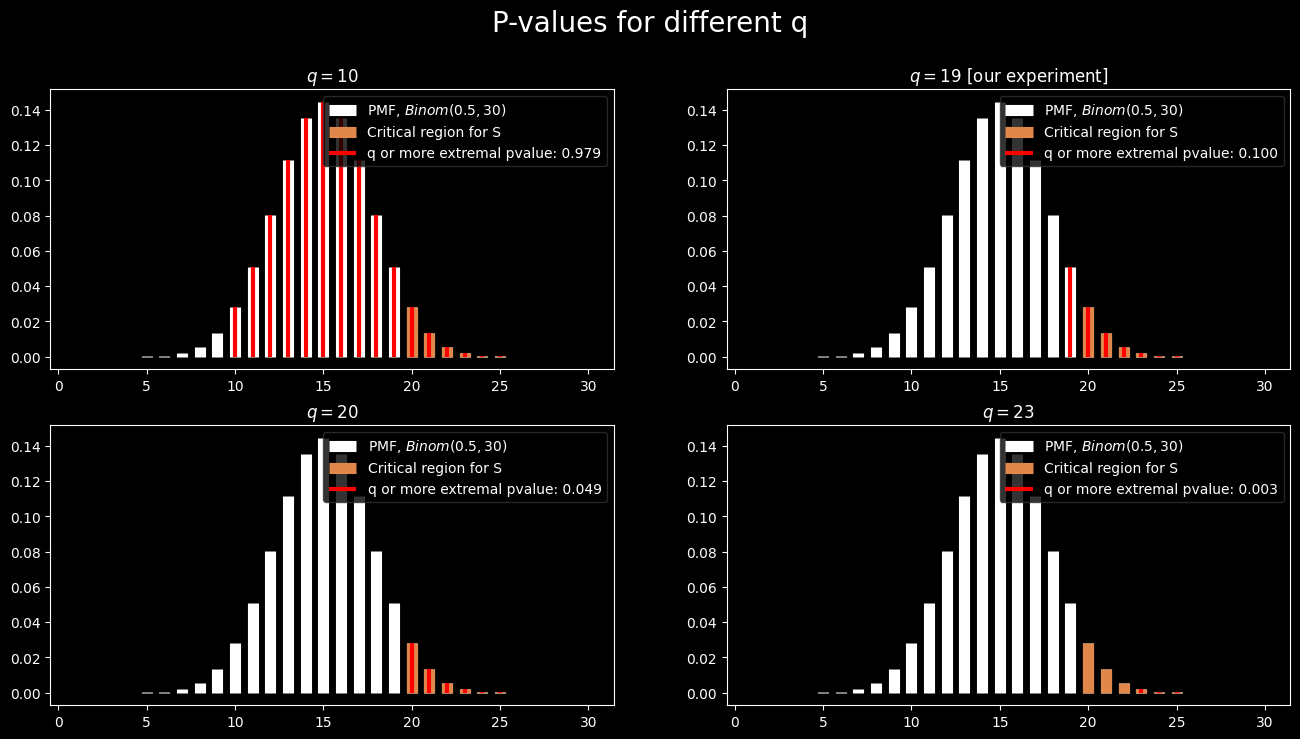

In [31]:
fig, axes = pyplot.subplots(2, 2, figsize=(16, 8))

for q, ax in zip(qs, axes.flatten()):
    ax.set_title(f'$q = {q}$' + (' [our experiment]' if q == 19 else ''))
    # строим вертикальные столбцы от 0 до вероятности
    ax.vlines(x_grid, 0, probs, linewidth=8.0, color='white', label='PMF, $Binom(0.5, 30)$')
    # отдельно изобразим критическую области критерия
    crit_reg = x_grid >= 20
    ax.vlines(x_grid[crit_reg], 0, probs[crit_reg], linewidth=8.0, label='Critical region for S')

    # посчитаем площадь более экстремальных значений
    pvalue = 1 - binom_h0.cdf(q - 1)
    # изобразим такие же и более экстремальные значения на графике
    more_extremal = x_grid >= q
    ax.vlines(
        x_grid[more_extremal], 0, probs[more_extremal], linewidth=3.0, color='red',
        label='q or more extremal pvalue: {:.3f}'.format(pvalue)
    )
    ax.legend()

pyplot.suptitle('P-values for different q', fontsize=20)
pyplot.show()

На графиках p-value - сумма площадей с красными линиями

Можно увидеть, что в критической области $p-value \leqslant \alpha$, а вне её $p-value > \alpha$. Именно такое правило и используется для принятия решения

$$ \mathsf{H}_0 \text{ отвергается } \Leftrightarrow p-value \leqslant \alpha $$


In [52]:
def get_p_value(n, m, mu=0.5, alpha=0.95):
    '''Ищем p-value для задачи с доставками
    
    Параметры:
        n: количество доставок в эксперименте
        m: количество успешных доставок
        mu: вероятность успеха в нулевой гипотезе
        alpha: уровень значимости критерия
        
    Возвращает:
        p-value
    '''
    binom_h0 = binom(n=n, p=mu)
    return 1 - binom_h0.cdf(m - 1)

In [53]:
print(get_p_value(30, 19))

0.10024421103298664


До этого момента нас интересовали отклонения от вероятности в $50\%$ только в одну сторону. И логично, ведь это продиктовано бизнес-смыслом. Только большая доля успешных доставок приведёт к успеху. И обычно при принятии решений так и бывает. **При тестировании нового решения или продукта рассматривают альтернативную гипотезу только в сторону улучшения**, потому что в противном случае нет смысла внедрять решение на всех пользователей.


Однако **иногда** может потребоваться доказывать отклонения в обе стороны, если вы проверяете какое-то предположение. Пусть вам дали монетку и просят проверить, честная она или нет. Монетка честная, если при подбрасываниях вероятность выпадения орла равна $0.5$. Вы подбрасываете монетку $30$ раз, каждый бросок &mdash; бернуллиевская величина, аналогично задаче с доставками. И нулевая гипотеза та же самая: $\mu = 0.5$. Но теперь мы хотим отвергать эту  гипотезу как в случае большой вероятности орла, так и в случае маленькой, соответственно проверяем *двустороннюю гипотезу*.

$$ \mathsf{H}_0: \mu = 0.5 $$
$$ \mathsf{H}_1: \mu \neq 0.5 $$

Воспользуемся той же статистикой $Q(\xi) = \sum \xi_i$

В этом случае всё тоже нетрудно - мы просто делим альфу пополам, и с каждой стороны оставляем критическую область для такого альфа

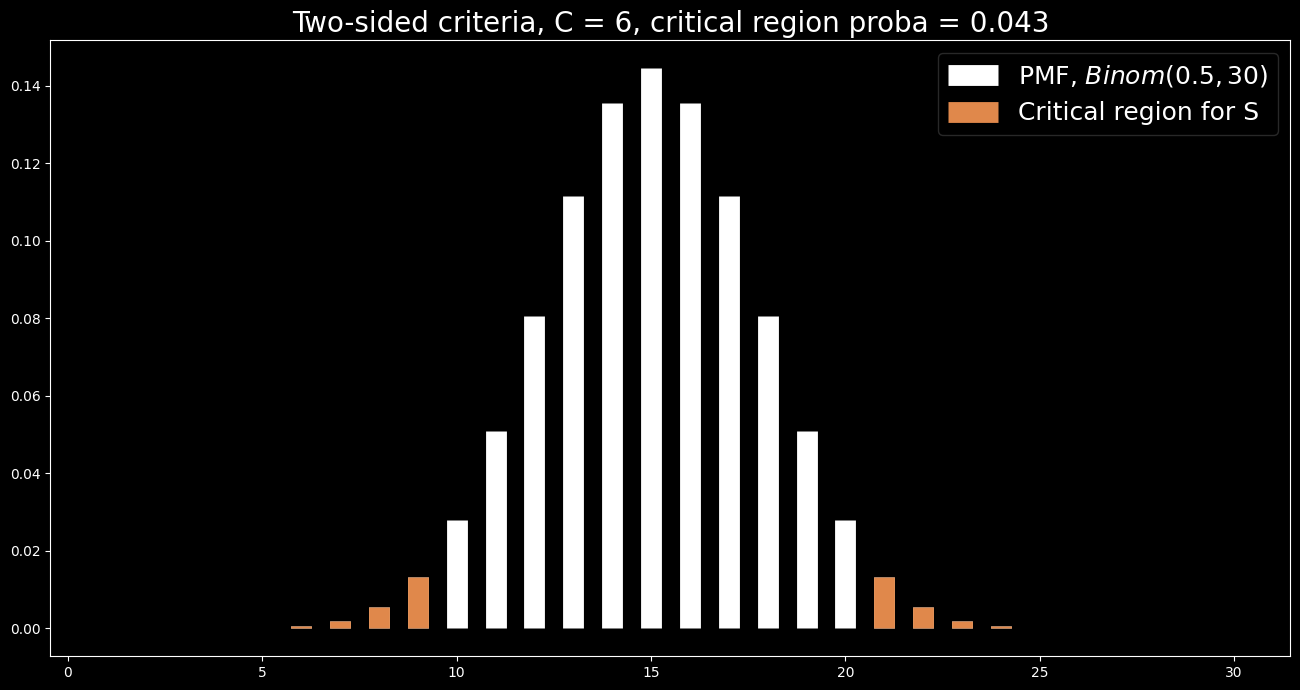

In [54]:
C = 6

pyplot.figure(figsize=(16, 8))

# строим вертикальные столбцы от 0 до вероятности
pyplot.vlines(x_grid, 0, probs, linewidth=15.0, color='white', label='PMF, $Binom(0.5, 30)$')
# отдельно изобразим критическую области критерия
crit_reg = numpy.abs(x_grid - 15) >= C
pyplot.vlines(x_grid[crit_reg], 0, probs[crit_reg], linewidth=15.0, label='Critical region for S')

rejection_prob = probs[crit_reg].sum()
pyplot.title('Two-sided criteria, C = {}, critical region proba = {:.3f}'.format(C, rejection_prob), fontsize=20)
pyplot.legend(fontsize=18)
pyplot.show()

In [55]:
# функция для подсчёта критического значения
def make_binom_criterion_two_sided(n, alpha=0.05):
    '''Строит критерий для задачи с доставкой для mu = 0.5 и двусторонней альтернативы
    
    Параметры:
        n: количество доставок в эксперименте
        mu: вероятность успеха в нулевой гипотезе
        alpha: уровень значимости критерия
        
    Возвращает:
        C для критерия S = {|Q - 15| >= C}
    '''
    # определяем границу справа для alpha / 2
    right_crit_val = make_binom_criterion(n, mu=0.5, alpha = alpha / 2)
    # считаем отклонение, начиная с которого отвергать
    diff = right_crit_val - 15
    return diff

In [56]:
make_binom_criterion_two_sided(30)

np.float64(6.0)

In [63]:
# функция для счёта p-value в случае симметричной с в

def pvalue_two_sided_sym(n, q):
    '''Считает pvalue для задачи с доставкой для mu = 0.5 и двусторонней альтернативы
    
    Параметры:
        n: количество доставок в эксперименте
        q: количество успешных доставок
        
    Возвращает:
        pvalue для критерия S = {|Q - 15| >= C}
    '''
    binom_h0 = binom(n=n, p=0.5)
    diff = numpy.abs(q - 15)
    # смотрим более экстремальные отклонения с правой стороны
    right_sq = 1 - binom_h0.cdf(15 + diff - 1)
    # смотрим более экстремальные отклонения с левой стороны
    left_sq = binom_h0.cdf(15 - diff)
    return left_sq + right_sq

In [71]:
pvalue_two_sided_sym(30, 21)

np.float64(0.04277394525706769)

В случае нессиметричного распределения критическое значение ищется аналогично

In [79]:
def make_binom_criterion_two_sided_antisym(n, mu, alpha=0.05):
    binom_h0 = binom(n=n, p=mu)
    # определяем границу справа для alpha / 2
    right_crit_val = binom_h0.ppf(1 - alpha / 2) + 1
    # считаем отклонение, начиная с которого отвергать
    left_crit_val = binom_h0.ppf(alpha / 2) - 1
    return left_crit_val, right_crit_val

In [80]:
make_binom_criterion_two_sided_antisym(30, 0.8)

(np.float64(18.0), np.float64(29.0))

Для подсчёта p-value сделаем следующее - посчитаем вероятность оказаться на q или правее, оказаться на q и левее, возьмём минимум из этих значений и умножим его на два

Этот критерий &mdash; объединение двух критериев уровня значимости $\frac{\alpha}{2}$, для каждого из которых можно посчитать p-value. Обозначим их как $p_1, p_2$. Первый критерий отвергается при $p_1 \leqslant \frac{\alpha}{2}$, второй при $p_2 \leqslant \frac{\alpha}{2}$. А наш объединённый, когда выполнено одно из этих условий, то есть

$$ 2p_1 \leqslant \alpha \vee 2p_2 \leqslant \alpha \Leftrightarrow 2 \cdot \min(p_1, p_2) \leqslant \alpha $$

Значит можно считать pvalue как $2  \min(p_1, p_2)$ и сравнивать с $\alpha$.

In [81]:
def pvalue_two_sided(n, q, mu=0.5):
    binom_h0 = binom(n=n, p=mu)
    pvalue_left = binom_h0.cdf(q)
    pvalue_right = 1 - binom_h0.cdf(q - 1)
    return 2 * min(pvalue_left, pvalue_right)

In [82]:
pvalue_two_sided(30, 18, 0.8)

np.float64(0.018986244349444917)

In [84]:
pvalue_two_sided(30, 23, 0.8)

np.float64(0.786060160548518)